This Colab Notebook demonstrates InstantStyle and ControlNet usage on SDXL model.

## Install dependency

In [1]:
!mkdir -p /content/sdxl_models/image_encoder

# Download IP-Adapter model checkpoints
!wget -P /content/sdxl_models/ https://huggingface.co/h94/IP-Adapter/resolve/main/sdxl_models/ip-adapter_sdxl.bin
!wget -P /content/sdxl_models/ https://huggingface.co/h94/IP-Adapter/resolve/main/sdxl_models/ip-adapter-plus_sdxl_vit-h.bin

# Download image_encoder model checkpoints
!wget -O /content/sdxl_models/image_encoder/pytorch_model.bin https://huggingface.co/h94/IP-Adapter/resolve/main/sdxl_models/image_encoder/pytorch_model.bin
!wget -O /content/sdxl_models/image_encoder/config.json https://huggingface.co/h94/IP-Adapter/resolve/main/sdxl_models/image_encoder/config.json




--2024-04-09 16:56:24--  https://huggingface.co/h94/IP-Adapter/resolve/main/sdxl_models/ip-adapter_sdxl.bin
Resolving huggingface.co (huggingface.co)... 18.239.50.49, 18.239.50.16, 18.239.50.103, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.49|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/6f/e5/6fe5d8840a1ab462e1b9f52fbeabac6bb30febaf56fb5a439f08cca6d1cf4372/7525f2731e9e86d1368e0b68467615d55dda459691965bdd7d37fa3d7fd84c12?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27ip-adapter_sdxl.bin%3B+filename%3D%22ip-adapter_sdxl.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1712939753&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxMjkzOTc1M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy82Zi9lNS82ZmU1ZDg4NDBhMWFiNDYyZTFiOWY1MmZiZWFiYWM2YmIzMGZlYmFmNTZmYjVhNDM5ZjA4Y2NhNmQxY2Y0MzcyLzc1MjVmMjczMWU5ZTg2ZDEzNjhlM

In [2]:
# Install required python modules
!pip install diffusers transformers torch einops accelerate

# Clone the repository
!git clone https://github.com/InstantStyle/InstantStyle.git  /content/InstantStyle


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 17.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinu

## Init

In [3]:
import sys
import os
sys.path.append("/content/InstantStyle")
#print(sys.path)

from PIL import Image

import torch
from ip_adapter import IPAdapterXL
from PIL import Image

print("DONE: modules required")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

DONE: modules required


In [4]:

base_model_path = "stabilityai/stable-diffusion-xl-base-1.0"
image_encoder_path = "/content/sdxl_models/image_encoder"
ip_ckpt = "/content/sdxl_models/ip-adapter_sdxl.bin"
device = "cuda"


In [5]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid



## Use Instant Style with Control Net  

In [6]:
# load style image
#path_to_style_image = "/content/InstantStyle/assets/4.jpg"
path_to_style_image = "/content/InstantStyle/assets/5.jpg"

style_image = Image.open(path_to_style_image )
style_image.resize((512, 512))
style_image


Output hidden; open in https://colab.research.google.com to view.

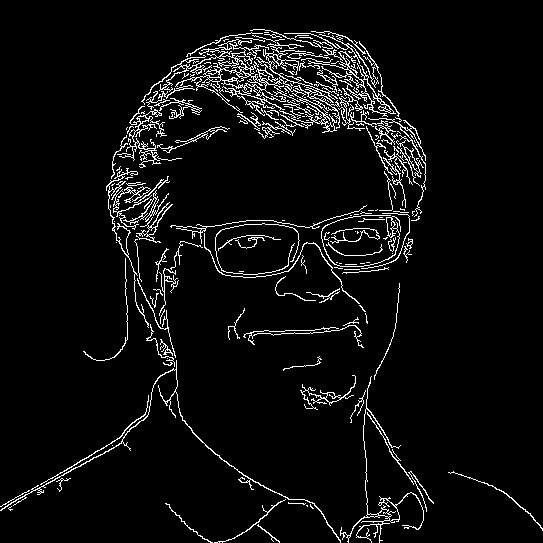

In [7]:
# setup control image
import cv2
path_to_control_image = "/content/InstantStyle/assets/yann-lecun.jpg"

input_image = cv2.imread(path_to_control_image)
detected_map = cv2.Canny(input_image, 50, 200)
canny_map = Image.fromarray(cv2.cvtColor(detected_map, cv2.COLOR_BGR2RGB))
canny_map

In [8]:
# load up the model to gpu

from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline

controlnet_path = "diffusers/controlnet-canny-sdxl-1.0"
controlnet = ControlNetModel.from_pretrained(controlnet_path, use_safetensors=False, torch_dtype=torch.float16).to(device)

# load SDXL pipeline
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    add_watermarker=False,
)
pipe.enable_vae_tiling()
#pipe.enable_sequential_cpu_offload()


# load ip-adapter
# target_blocks=["block"] for original IP-Adapter
# target_blocks=["up_blocks.0.attentions.1"] for style blocks only
# target_blocks = ["up_blocks.0.attentions.1", "down_blocks.2.attentions.1"] # for style+layout blocks
ip_model = IPAdapterXL(pipe, image_encoder_path, ip_ckpt, device, target_blocks=["up_blocks.0.attentions.1"])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

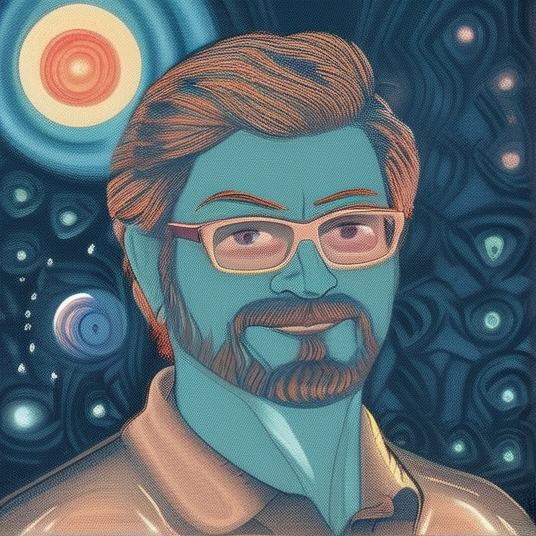

In [12]:
# generate stylished image
positive_prompt="a man, masterpiece, best quality, high quality"
negative_prompt= "text, watermark, lowres, low quality, worst quality, deformed, glitch, low contrast, noisy, saturation, blurry"

images = ip_model.generate(pil_image=style_image,
                           prompt=positive_prompt,
                           negative_prompt=negative_prompt,
                           scale=1.0,
                           guidance_scale=5,
                           seed=777,
                           num_samples=1,
                           num_inference_steps=100,
                           image=canny_map,
                           controlnet_conditioning_scale=0.6,
                          )
images[0]
